In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-eu.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [0]:
import findspark
findspark.init("spark-2.4.4-bin-hadoop2.7") # SPARK_HOME
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
!pip install ARCH

     |████████████████████████████████| 716kB 2.7MB/s 


In [0]:
import os
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
!pwd
os.chdir('gdrive/Shared drives/brazilian-ecommerce')
!pwd
!ls

### Loading Merged Data

In [0]:
df_product = spark.read.csv("/content/gdrive/Shared drives/brazilian-ecommerce/olist_products_dataset.csv", inferSchema=True, header=True)  ## Products dataset
df_category_name_translation = spark.read.csv("/content/gdrive/brazilian-ecommerce/product_category_name_translation.csv", inferSchema=True, header=True)  ## Product translation to english

In [0]:
new_product = df_product.join(df_category_name_translation, on='product_category_name', how='left')

In [0]:
final_order = spark.read.format('json').\
            load('/content/gdrive/Shared drives/brazilian-ecommerce/final_order.json')

In [0]:
final_order.printSchema()

In [0]:
print final_order.columns ## Column Names
print "Row Count: ", final_order.count() ## Row Count
print "Column Count: ", len(final_order.columns) ## Column Count

### Sales Analysis
In this session, we just analyse the sales data and the results will give some recommendation to the platform to improve the user experience. Or the results will show the performance of the platform during 2016-2018.

#### Prepare the Sales Data

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from pyspark.mllib.linalg import SparseVector, DenseVector
from pyspark.mllib.clustering import KMeans, KMeansModel
from pyspark.sql.functions import year, month, dayofmonth

In [0]:
# Select concerning features from the merged data
sales_analysis = final_order.select('seller_id', 'order_id', 'customer_id','order_purchase_timestamp'\
                                    ,'customer_unique_id','total_payment','payment_type_count','payment_type_value'\
                                    ,'product_id','order_item_id','price','freight_value','product_category_name_english','id')
# sales_analysis.show()

In [0]:
# create new features based on "order purchase timestamp"
sales_analysis = sales_analysis.select('seller_id', 'order_id', 'customer_id','customer_unique_id','total_payment','payment_type_count','payment_type_value'\
                      ,'product_id','order_item_id','price','freight_value','product_category_name_english','id'\
                      ,year("order_purchase_timestamp").alias('year'), month("order_purchase_timestamp").alias('month')\
                      , dayofmonth("order_purchase_timestamp").alias('day'))

In [0]:
sales_analysis.show()

+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+-------------+-----+-------------+-----------------------------+---+----+-----+---+
|           seller_id|            order_id|         customer_id|  customer_unique_id|total_payment|  payment_type_count|  payment_type_value|          product_id|order_item_id|price|freight_value|product_category_name_english| id|year|month|day|
+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+-------------+-----+-------------+-----------------------------+---+----+-----+---+
|062ce95fa2ad4dfae...|b6fa6ea37aeeb90c9...|e2dc0b0cef1781793...|4f308d513ccac2840...|       100.91|  [[0], 4, 0, [1.0]]|[[0], 4, 0, [100....|8a4505505378c8f5d...|            1| 79.9|        21.01|                health_beauty|  0|2017|    4| 24|
|062ce95fa2ad4df

In [0]:
sales_analysis.printSchema()

root
 |-- seller_id: string (nullable = true)
 |-- order_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- customer_unique_id: string (nullable = true)
 |-- total_payment: double (nullable = true)
 |-- payment_type_count: struct (nullable = true)
 |    |-- indices: array (nullable = true)
 |    |    |-- element: long (containsNull = true)
 |    |-- size: long (nullable = true)
 |    |-- type: long (nullable = true)
 |    |-- values: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |-- payment_type_value: struct (nullable = true)
 |    |-- indices: array (nullable = true)
 |    |    |-- element: long (containsNull = true)
 |    |-- size: long (nullable = true)
 |    |-- type: long (nullable = true)
 |    |-- values: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |-- product_id: string (nullable = true)
 |-- order_item_id: long (nullable = true)
 |-- price: double (nullable = true)
 |-- freight_value: 

In [0]:
# convert dataframe to rdd
sales_rdd = sales_analysis.rdd

#### 0. Sales volume each month

In [0]:
# key: value = Year&Month&volume of each order
product_volume = sales_rdd.map(lambda s: ((s[13],s[14]),s[4])).filter(lambda s: s[1]!=None).reduceByKey(lambda a,b: a+b)
# key: value = Year&Month: list of unique categories in this month
# product_cate_M2 = product_cate_M1.map(lambda s: ((s[0][0],s[0][1]),s[0][2])).groupByKey().map(lambda s: (s[0],[str(i) for i in s[1]]))
product_volume_list = product_volume.collect()
product_volume.count()

24

In [0]:
# sort by the Year & Month
product_volume_list.sort()

In [0]:
product_volume_time = []
product_volume_value = []
for i in range(len(product_volume_list)-1):
  product_volume_time.append(product_volume_list[i][0])
  product_volume_value.append(product_volume_list[i][1])

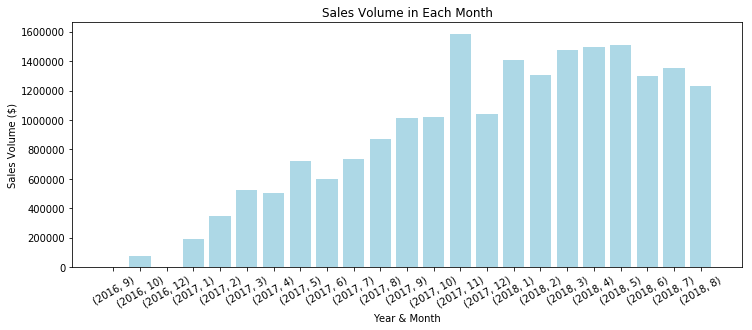

In [0]:
# plot
# x = Year & Month
# y = delta count of product categories
x = np.array([i for i in range(len(product_volume_time))])
fig = plt.figure(figsize=(12,4.5))

ax = fig.add_subplot(111)
ax.bar(x, product_volume_value, color='lightblue', linewidth=2)
plt.xticks(x, product_volume_time, rotation = 30)
plt.xlabel('Year & Month')
plt.ylabel('Sales Volume ($)')
plt.title('Sales Volume in Each Month')
plt.show()

#### 1. New product categories each month

In [0]:
# key: value = Year&Month&Category: count
product_cate_M1 = sales_rdd.map(lambda s: ((s[13],s[14],s[11]),1)).reduceByKey(lambda a,b: a+b)
# key: value = Year&Month: list of unique categories in this month
product_cate_M2 = product_cate_M1.map(lambda s: ((s[0][0],s[0][1]),s[0][2])).groupByKey().map(lambda s: (s[0],[str(i) for i in s[1]]))
product_cate_list = product_cate_M2.collect()
product_cate_M1.take(2)

[((2017, 5, u'office_furniture'), 56),
 ((2017, 5, u'furniture_mattress_and_upholstery'), 3)]

In [0]:
# sort by the Year & Month
product_cate_list.sort()

In [0]:
# find the delta count: (count of categories in this month) - (count of categories in last month)
product_delta_dic = {}
product_delta_time = []
product_delta_value = []
for i in range(len(product_cate_list)):
    n = 0
    m = product_cate_list[i][0]
    if i == 0:
        n = len(product_cate_list[i][1])
    if i != 0:
        for x in product_cate_list[i][1]:
            if x not in product_cate_list[i-1][1]:
                n += 1
            if x in product_cate_list[i-1][1]:
                n = n
    product_delta_dic.update({m:n})
    product_delta_time.append(m)
    product_delta_value.append(n)

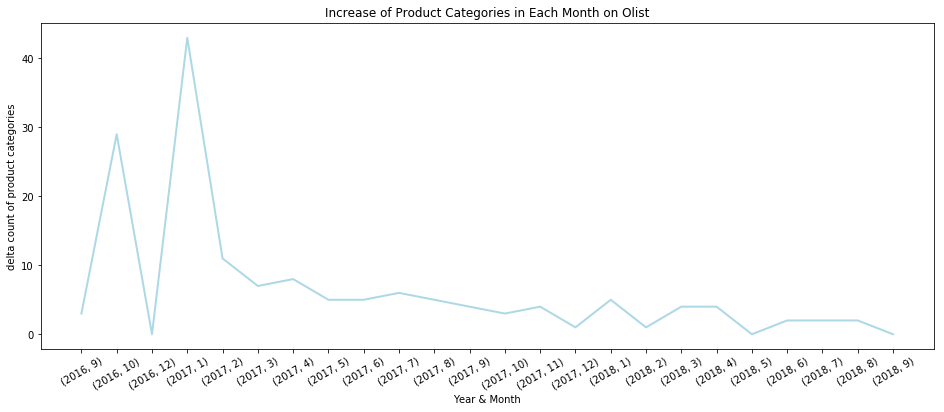

In [0]:
# plot
# x = Year & Month
# y = delta count of product categories
x = np.array([i for i in range(len(product_delta_time))])
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(111)
ax.plot(x, product_delta_value, color='lightblue', linewidth=2)
plt.xticks(x, product_delta_time, rotation = 30)
plt.xlabel('Year & Month')
plt.ylabel('delta count of product categories')
plt.title('Increase of Product Categories in Each Month on Olist')
plt.show()

#### 2. Increase of Seller Each Month

In [0]:
# key: value = Year&Month&Seller: count
sellers_M1 = sales_rdd.map(lambda s: ((s[13],s[14],s[0]),1)).reduceByKey(lambda a,b: a+b)
# key: value = Year&Month: list of unique sellers in this month
sellers_M2 = sellers_M1.map(lambda s: ((s[0][0],s[0][1]),s[0][2])).groupByKey().map(lambda s: (s[0],[str(i) for i in s[1]]))
sellers_list = sellers_M2.collect()

In [0]:
# sort by the Year & Month
sellers_list.sort()

In [0]:
# find the delta count: (count of sellers in this month) - (count of sellers in last month)
sellers_delta_dic = {}
sellers_delta_time = []
sellers_delta_value = []
for i in range(len(sellers_list)):
    n = 0
    m = sellers_list[i][0]
    if i == 0:
        n = len(sellers_list[i][1])
    if i != 0:
        for x in sellers_list[i][1]:
            if x not in sellers_list[i-1][1]:
                n += 1
            if x in sellers_list[i-1][1]:
                n = n
    sellers_delta_dic.update({m:n})
    sellers_delta_time.append(m)
    sellers_delta_value.append(n)

In [0]:
sellers_value = []
for i in range(len(sellers_list)):
  if i == 0:
    sellers_value.append(sellers_delta_value[i])
  else:
    k = sellers_value[i-1] + sellers_delta_value[i]
    sellers_value.append(k)

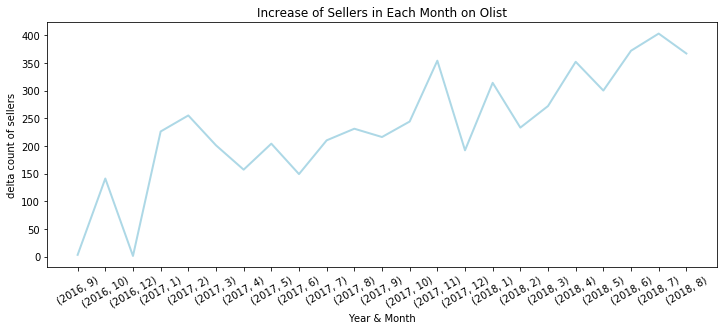

In [0]:
# plot
# x = Year & Month
# y = delta count of sellers
x = np.array([i for i in range(len(sellers_delta_time)-1)])
fig = plt.figure(figsize=(12,4.5))
ax = fig.add_subplot(111)
ax.plot(x, sellers_delta_value[:-1], color='lightblue', linewidth=2)
plt.xticks(x, sellers_delta_time[:-1], rotation = 30)
plt.xlabel('Year & Month')
plt.ylabel('delta count of sellers')
plt.title('Increase of Sellers in Each Month on Olist')
plt.show()

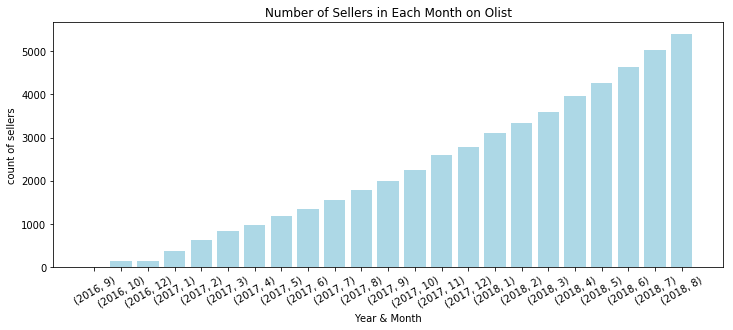

In [0]:
# plot
# x = Year & Month
# y = delta count of sellers
x = np.array([i for i in range(len(sellers_delta_time)-1)])
fig = plt.figure(figsize=(12,4.5))
ax = fig.add_subplot(111)
ax.bar(x, sellers_value[:-1], color='lightblue', linewidth=2)
plt.xticks(x, sellers_delta_time[:-1], rotation = 30)
plt.xlabel('Year & Month')
plt.ylabel('count of sellers')
plt.title('Number of Sellers in Each Month on Olist')
plt.show()

#### 3. Categories purchased at high frequency in each year

In [0]:
# key: value = Year&Category: count
product_cate_freq = sales_rdd.map(lambda s: ((s[13],str(s[11])),1)).reduceByKey(lambda a,b: a+b)
product_cate_freq.take(1)

[((2017, 'signaling_and_security'), 46)]

In [0]:
# convert rdd to df
product_cate_freq_DF = product_cate_freq.map(lambda s: (s[0][0],s[0][1],s[1])).toDF(["year","product","number"])
product_cate_freq_DF.show()

+----+--------------------+------+
|year|             product|number|
+----+--------------------+------+
|2017|signaling_and_sec...|    46|
|2017|        garden_tools|  2463|
|2018| luggage_accessories|   494|
|2016|       watches_gifts|     5|
|2016|           perfumery|    33|
|2017|             flowers|     8|
|2018|kitchen_dining_la...|   161|
|2018|       fashion_sport|     5|
|2018|computers_accesso...|  4708|
|2016|    air_conditioning|    10|
|2017|                toys|  2602|
|2017|               audio|   167|
|2018|costruction_tools...|    81|
|2016|                baby|    14|
|2018|       watches_gifts|  3703|
|2018|        dvds_blu_ray|    25|
|2018|       fashion_shoes|    71|
|2017|fashion_childrens...|     5|
|2018|            pet_shop|  1159|
|2018|          la_cuisine|     4|
+----+--------------------+------+
only showing top 20 rows



In [0]:
# filter subset according to year
product_cate_freq_DF_2016 = product_cate_freq_DF.filter(product_cate_freq_DF.year == 2016)
product_cate_freq_DF_2017 = product_cate_freq_DF.filter(product_cate_freq_DF.year == 2017)
product_cate_freq_DF_2018 = product_cate_freq_DF.filter(product_cate_freq_DF.year == 2018)

In [0]:
# Since the numbers of months in each year are not equal, devide the count by the number of months
product_cate_freq_DF_2016 = product_cate_freq_DF_2016.withColumn('average number',product_cate_freq_DF_2016.number/3.0)
product_cate_freq_DF_2017 = product_cate_freq_DF_2017.withColumn('average number',product_cate_freq_DF_2017.number/12.0)
product_cate_freq_DF_2018 = product_cate_freq_DF_2018.withColumn('average number',product_cate_freq_DF_2018.number/9.0)

In [0]:
blank_product_cate = new_product.select("product_category_name_english").distinct()

In [0]:
# add the categories do not be bought in each year
product_cate_freq_df_2016 = blank_product_cate.join(product_cate_freq_DF_2016, product_cate_freq_DF_2016.product == blank_product_cate.product_category_name_english, how='left')
product_cate_freq_df_2017 = blank_product_cate.join(product_cate_freq_DF_2017, product_cate_freq_DF_2017.product == blank_product_cate.product_category_name_english, how='left')
product_cate_freq_df_2018 = blank_product_cate.join(product_cate_freq_DF_2018, product_cate_freq_DF_2018.product == blank_product_cate.product_category_name_english, how='left')
product_cate_freq_df_2016.count()

72

In [0]:
# sort the df by product_categories
product_cate_freq_new_2016 = product_cate_freq_df_2016.drop("product").withColumnRenamed('product_category_name_english', 'product_cate').sort('product_cate', ascending=True)
product_cate_freq_new_2017 = product_cate_freq_df_2017.drop("product").withColumnRenamed('product_category_name_english', 'product_cate').sort('product_cate', ascending=True)
product_cate_freq_new_2018 = product_cate_freq_df_2018.drop("product").withColumnRenamed('product_category_name_english', 'product_cate').sort('product_cate', ascending=True)

In [0]:
product_cate_freq_new_2018.show()

+--------------------+----+------+------------------+
|        product_cate|year|number|    average number|
+--------------------+----+------+------------------+
|                null|null|  null|              null|
|agro_industry_and...|2018|   151| 16.77777777777778|
|    air_conditioning|2018|   157|17.444444444444443|
|                 art|2018|   168|18.666666666666668|
|arts_and_craftman...|2018|    22|2.4444444444444446|
|               audio|2018|   195|21.666666666666668|
|                auto|2018|  2619|             291.0|
|                baby|2018|  1776|197.33333333333334|
|      bed_bath_table|2018|  5884| 653.7777777777778|
|books_general_int...|2018|   316|35.111111111111114|
|      books_imported|2018|    44| 4.888888888888889|
|     books_technical|2018|   222|24.666666666666668|
|   cds_dvds_musicals|2018|     1|0.1111111111111111|
|  christmas_supplies|2018|    90|              10.0|
|          cine_photo|2018|    64| 7.111111111111111|
|           computers|2018| 

In [0]:
# convert pyspark dataframe to pandas
product_cate_freq_pd_2016 = product_cate_freq_new_2016.toPandas()
product_cate_freq_pd_2017 = product_cate_freq_new_2017.toPandas()
product_cate_freq_pd_2018 = product_cate_freq_new_2018.toPandas()

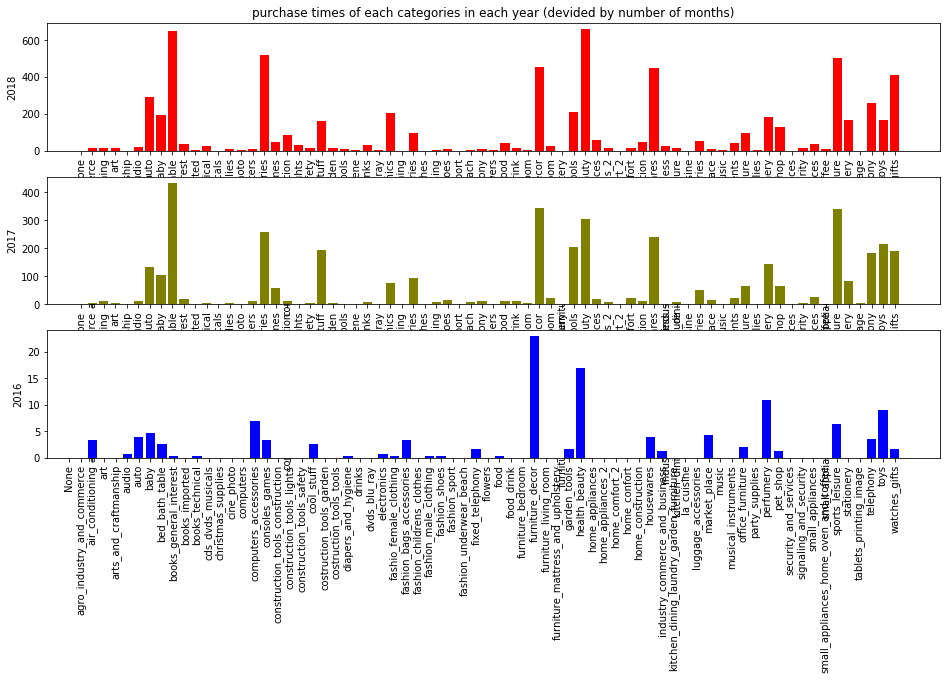

In [0]:
# plot in barcharts
x = np.array([i for i in range(len(product_cate_freq_pd_2016))])
plt.figure(figsize=(16,8))


plt.subplot(3, 1, 1)
plt.bar( x, 'average number', data=product_cate_freq_pd_2018, color='red', linewidth=2, label=2018)
plt.xticks(x, product_cate_freq_pd_2018.product_cate, rotation = 90)
# plt.xticks([])
plt.ylabel('2018')
plt.title('purchase times of each categories in each year (devided by number of months)')

plt.subplot(3, 1, 2)
plt.bar( x, 'average number', data=product_cate_freq_pd_2017, color='olive', linewidth=2, label = 2017)
plt.xticks(x, product_cate_freq_pd_2018.product_cate, rotation = 90)
# plt.xticks([])
plt.ylabel('2017')

plt.subplot(3, 1, 3)
plt.bar( x, 'average number', data=product_cate_freq_pd_2016, color='blue', linewidth=2, label = 2016)
plt.xticks(x, product_cate_freq_pd_2018.product_cate, rotation = 90)
plt.ylabel('2016')

plt.show()

#### 4. Which two products always bought together (coupon? set?) in/ not in each seller

In [0]:
# conbine unique items (items bought multiple times will just count once) in the same order id
sales_basket = sales_rdd.map(lambda s: (s[1], s[7])).groupByKey().map(lambda s:list(s[1])).map(lambda s: list(dict.fromkeys(s)))
sales_basket.count()

98666

In [0]:
sales_basket.take(5)

[[u'046eee903d62294ffad4e38ae6aa730e'],
 [u'9b5db368c0daee4e693aa981f17d0010'],
 [u'2efbce46d36d9af306d4300db163b276'],
 [u'47cc9106e1bc828d424f9439933ca075'],
 [u'1379437fdb5620cec92ee180f1f16ebd']]

In [0]:
# delete the baskets which just contain one unique item
def delete_1(s):
  if len(s) == 1:
    return s, "F"
  if len(s) >= 2:
    return s, "T"
sales_basket_2 = sales_basket.map(delete_1).filter(lambda s: s[1] == "T").map(lambda s: s[0])
sales_basket_2.take(2)

[[u'cdc9d87e17ccf98f35634e6c3b77073e', u'adb1f1939b613f3078806b6afcca0e51'],
 [u'9926323a78ee2ba9e3b282efce191cff', u'bf2365078da8fad96e4c22880492dd9a']]

In [0]:
# convert basket to pairs
def pair(s):
    lst=[]
    for i in range(0, len(s)-1):
        for j in range(i+1, len(s)):
             lst.append((s[i],s[j]))
    return lst

twoProFreq = sales_basket_2.map(pair).flatMap(lambda x: x).map(lambda p: [p,1])
print twoProFreq.take(5)

[[(u'cdc9d87e17ccf98f35634e6c3b77073e', u'adb1f1939b613f3078806b6afcca0e51'), 1], [(u'9926323a78ee2ba9e3b282efce191cff', u'bf2365078da8fad96e4c22880492dd9a'), 1], [(u'9e2ce829b01f3d1a0a9d5ddf7ee21864', u'de17feec1983829fec4bc58cadaa43f3'), 1], [(u'158102fe543dbaeb84d87811bfe06d0d', u'414c53fa9c5cc4a0390682aeb2e25ec1'), 1], [(u'd2d39433df84064b1556612cc52cefca', u'dc52f0f5d3ec37a93eaf956cde4e5d2c'), 1]]


In [0]:
# aggregate the same pairs
twoProFreq_agg = twoProFreq.reduceByKey(lambda a,b: a+b).sortBy(lambda x: x[1], ascending = False)

In [0]:
twoProFreq_agg.take(3)

[((u'36f60d45225e60c7da4558b070ce4b60', u'e53e557d5a159f5aa2c5e995dfdf244b'),
  34),
 ((u'35afc973633aaeb6b877ff57b2793310', u'99a4788cb24856965c36a24e339b6058'),
  29),
 ((u'f4f67ccaece962d013a4e1d7dc3a61f7', u'4fcb3d9a5f4871e8362dfedbdb02b064'),
  17)]

In [0]:
# sort the pairs
from pyspark.sql.functions import col

freqTwoPro_sorted = twoProFreq_agg.filter(lambda x: x[1]>5).sortBy(lambda x: x[1], ascending = False)

# Each line is converted to a tuple.
freqTwoProTuples = freqTwoPro_sorted.map(lambda p: (p[0][0], p[0][1], p[1]))

# The schema is encoded in a string.

freqTwoProDF = freqTwoProTuples.toDF(["product_id_1", "product_id_2", "frequency"])
product_info = new_product.select("product_id","product_category_name_english")
freqTwoProDF1 = freqTwoProDF.join(product_info, freqTwoProDF.product_id_1==product_info.product_id, how='left').drop("product_id").withColumnRenamed("product_category_name_english","product_cate_1")
freqTwoProDF2 = freqTwoProDF1.join(product_info, freqTwoProDF.product_id_2==product_info.product_id, how='left').drop("product_id").withColumnRenamed("product_category_name_english","product_cate_2")

print "The frequent product pairs are as follow."
print freqTwoProDF2.show(50)

The frequent product pairs are as follow.
+--------------------+--------------------+---------+--------------------+--------------------+
|        product_id_1|        product_id_2|frequency|      product_cate_1|      product_cate_2|
+--------------------+--------------------+---------+--------------------+--------------------+
|3f14d740544f37ece...|36f60d45225e60c7d...|       12|computers_accesso...|computers_accesso...|
|98d61056e0568ba04...|060cb19345d90064d...|        6|                auto|                auto|
|5b8a5a9417210b1b8...|e5ae72c62ebfa7086...|        6|computers_accesso...|computers_accesso...|
|5fc3e6a4b52b0c414...|5d790355cbeded0cd...|        6|computers_accesso...|computers_accesso...|
|36f60d45225e60c7d...|e53e557d5a159f5aa...|       34|computers_accesso...|computers_accesso...|
|53759a2ecddad2bb8...|389d119b48cf3043d...|        9|        garden_tools|        garden_tools|
|422879e10f4668299...|389d119b48cf3043d...|       11|        garden_tools|        garden_tools

In [0]:
# another method
from pyspark.mllib.fpm import FPGrowth
model = FPGrowth.train(sales_basket_2, minSupport=0.005, numPartitions=10)   #minSupport=times/total baskets number

result = model.freqItemsets().collect()
print('---------------------------')
for fi in result:
    print(fi)

---------------------------
FreqItemset(items=[u'0bcc3eeca39e1064258aa1e932269894'], freq=18)
FreqItemset(items=[u'99a4788cb24856965c36a24e339b6058'], freq=52)
FreqItemset(items=[u'f4f67ccaece962d013a4e1d7dc3a61f7'], freq=18)
FreqItemset(items=[u'f4f67ccaece962d013a4e1d7dc3a61f7', u'4fcb3d9a5f4871e8362dfedbdb02b064'], freq=17)
FreqItemset(items=[u'36f60d45225e60c7da4558b070ce4b60'], freq=48)
FreqItemset(items=[u'e53e557d5a159f5aa2c5e995dfdf244b'], freq=38)
FreqItemset(items=[u'e53e557d5a159f5aa2c5e995dfdf244b', u'36f60d45225e60c7da4558b070ce4b60'], freq=34)
FreqItemset(items=[u'35afc973633aaeb6b877ff57b2793310'], freq=36)
FreqItemset(items=[u'35afc973633aaeb6b877ff57b2793310', u'99a4788cb24856965c36a24e339b6058'], freq=29)
FreqItemset(items=[u'422879e10f46682990de24d770e7f83d'], freq=32)
FreqItemset(items=[u'53759a2ecddad2bb87a079a1f1519f73'], freq=29)
FreqItemset(items=[u'389d119b48cf3043d311335e499d9c6b'], freq=28)
FreqItemset(items=[u'368c6c730842d78016ad823897a372db'], freq=27)
Fre

#### 5. Tendency of payment method

##### According to Payment Amount

In [0]:
# key: value = Year&Month: payment_type_value
payment_type_B_amount = sales_rdd.map(lambda s:[(s[13],s[14]),s[6]])
payment_type_B_amount.take(1)

[[(2017, 4), Row(indices=[0], size=4, type=0, values=[100.91])]]

In [0]:
# convert struct into sparse vector (saving json result in this)
def structToSparseVector(s):
    ids = []
    vals = []
    if s[1] == None:
        a = None
    if s[1] != None:
        for i in s[1].indices:
            ids.append(i)
        for k in s[1].values:
            vals.append(k)
        a = SparseVector(4, ids, vals)
    return s[0], a
payment_type_B_amount = payment_type_B_amount.map(structToSparseVector)
payment_type_B_amount.take(10)

[((2017, 4), SparseVector(4, {0: 100.91})),
 ((2017, 3), SparseVector(4, {1: 56.42})),
 ((2017, 8), SparseVector(4, {0: 59.82})),
 ((2017, 5), SparseVector(4, {1: 40.22, 3: 16.78})),
 ((2017, 6), SparseVector(4, {0: 54.38})),
 ((2017, 5), SparseVector(4, {1: 65.53})),
 ((2017, 9), SparseVector(4, {1: 243.12})),
 ((2017, 4), SparseVector(4, {1: 312.25})),
 ((2017, 2), SparseVector(4, {1: 208.07})),
 ((2017, 1), SparseVector(4, {1: 119.36}))]

In [0]:
# aggregate amount based on Year&Month and payment type
def aggreList(a,b):
  if a == []:
    A = [0.0,0.0,0.0,0.0]
  if a != []:
    A = a
  if b == []:
    B = [0.0,0.0,0.0,0.0]
  if b != []:
    B = b
  k = []
  for i in range(len(A)):
    k.append(A[i]+B[i])
  return k
payment_type_B_amount_agg = payment_type_B_amount.map(lambda s: (s[0], DenseVector(s[1])))\
                                                 .map(lambda s: (s[0],list([i for i in s[1]])))\
                                                 .reduceByKey(aggreList)
payment_type_B_amount_agg.filter(lambda s: s[0]==(2016, 9)).take(2)

[((2016, 9), [0.0, 347.52, 0.0, 0.0])]

In [0]:
# sort the Year&Month
payment_type_B_amount_sort = payment_type_B_amount_agg.sortByKey()
payment_type_B_amount_sort.take(5)

[((2016, 9), [0.0, 347.52, 0.0, 0.0]),
 ((2016, 10),
  [13981.390000000003, 58874.37999999999, 241.73, 817.0799999999999]),
 ((2016, 12), [0.0, 19.62, 0.0, 0.0]),
 ((2017, 1), [33013.73, 148538.17999999988, 788.19, 5439.310000000001]),
 ((2017, 2), [72366.67999999996, 263399.3099999996, 1664.04, 6704.76])]

In [0]:
# "boleto":0,"credit_card":1,"debit_card":2,"voucher":3
month = payment_type_B_amount_sort.map(lambda s: s[0]).collect()
boleto = payment_type_B_amount_sort.map(lambda s: s[1][0]).collect()
credit_card = payment_type_B_amount_sort.map(lambda s: s[1][1]).collect()
debit_card = payment_type_B_amount_sort.map(lambda s: s[1][2]).collect()
voucher = payment_type_B_amount_sort.map(lambda s: s[1][3]).collect()

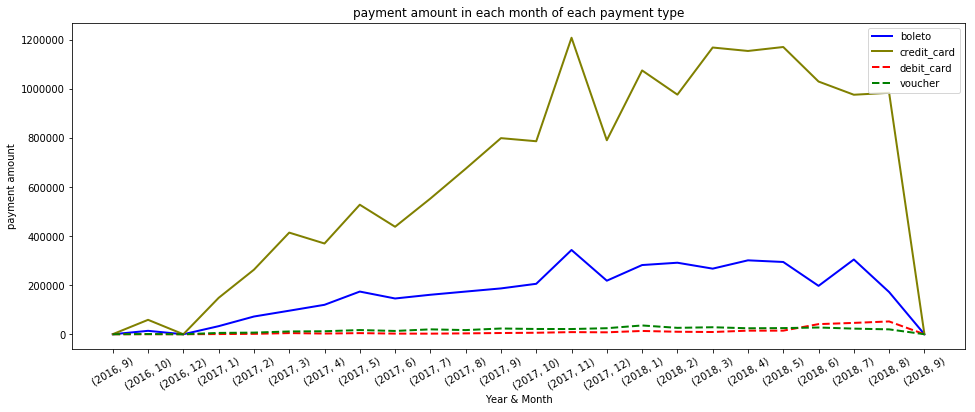

In [0]:
# plot
x = np.array([i for i in range(len(month))])
plt.figure(figsize=(16,6))
plt.plot( x, boleto, marker='', color='blue', linewidth=2, label = "boleto")
plt.plot( x, credit_card, marker='', color='olive', linewidth=2, label = "credit_card")
plt.plot( x, debit_card, marker='', color='red', linewidth=2, linestyle='dashed', label="debit_card")
plt.plot( x, voucher, marker='', color='green', linewidth=2, linestyle='dashed', label="voucher")
plt.xticks(x, month, rotation = 30)
plt.title('payment amount in each month of each payment type')
plt.xlabel('Year & Month')
plt.ylabel('payment amount')
plt.legend()

##### According to Payment count

In [0]:
# key: value = Year&Month: payment_type_count
payment_type_B_count = sales_rdd.map(lambda s:[(s[13],s[14]),s[5]])
payment_type_B_count.take(1)

[[(2017, 4), Row(indices=[0], size=4, type=0, values=[1.0])]]

In [0]:
# convert struct into sparse vector (saving json result in this)
payment_type_B_count = payment_type_B_count.map(structToSparseVector)
payment_type_B_count.take(10)

[((2017, 4), SparseVector(4, {0: 1.0})),
 ((2017, 3), SparseVector(4, {1: 1.0})),
 ((2017, 8), SparseVector(4, {0: 1.0})),
 ((2017, 5), SparseVector(4, {1: 2.0, 3: 1.0})),
 ((2017, 6), SparseVector(4, {0: 1.0})),
 ((2017, 5), SparseVector(4, {1: 6.0})),
 ((2017, 9), SparseVector(4, {1: 10.0})),
 ((2017, 4), SparseVector(4, {1: 5.0})),
 ((2017, 2), SparseVector(4, {1: 3.0})),
 ((2017, 1), SparseVector(4, {1: 1.0}))]

In [0]:
# aggregate amount based on Year&Month and payment type
payment_type_B_count_agg = payment_type_B_count.map(lambda s: (s[0], DenseVector(s[1])))\
                                                 .map(lambda s: (s[0],list([i for i in s[1]])))\
                                                 .reduceByKey(aggreList)
payment_type_B_count_agg.filter(lambda s: s[0]==(2016, 9)).take(2)

[((2016, 9), [0.0, 5.0, 0.0, 0.0])]

In [0]:
# sort the Year&Month
payment_type_B_count_sort = payment_type_B_count_agg.sortByKey()
payment_type_B_count_sort.take(5)

[((2016, 9), [0.0, 5.0, 0.0, 0.0]),
 ((2016, 10), [71.0, 1339.0, 2.0, 22.0]),
 ((2016, 12), [0.0, 1.0, 0.0, 0.0]),
 ((2017, 1), [232.0, 2727.0, 10.0, 68.0]),
 ((2017, 2), [438.0, 5258.0, 14.0, 122.0])]

In [0]:
# "boleto":0,"credit_card":1,"debit_card":2,"voucher":3
month_2 = payment_type_B_count_sort.map(lambda s: s[0]).collect()
boleto_2 = payment_type_B_count_sort.map(lambda s: s[1][0]).collect()
credit_card_2 = payment_type_B_count_sort.map(lambda s: s[1][1]).collect()
debit_card_2 = payment_type_B_count_sort.map(lambda s: s[1][2]).collect()
voucher_2 = payment_type_B_count_sort.map(lambda s: s[1][3]).collect()

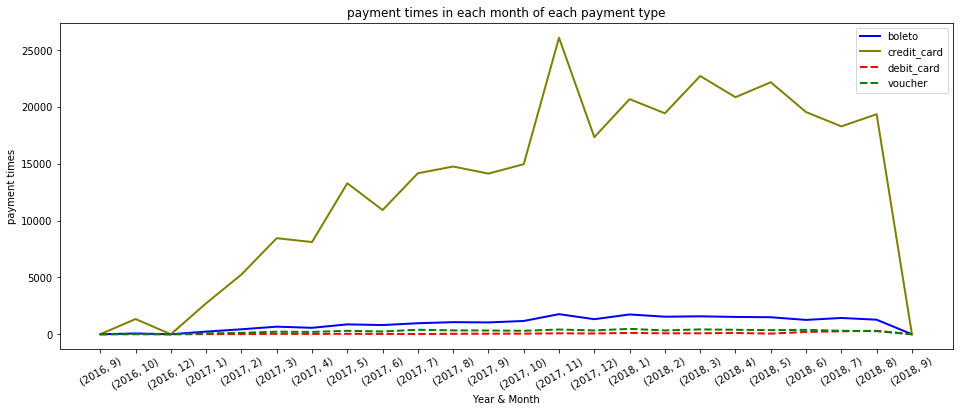

In [0]:
# plot
x = np.array([i for i in range(len(month_2))])
plt.figure(figsize=(16,6))
plt.plot( x, boleto_2, marker='', color='blue', linewidth=2, label = "boleto")
plt.plot( x, credit_card_2, marker='', color='olive', linewidth=2, label = "credit_card")
plt.plot( x, debit_card_2, marker='', color='red', linewidth=2, linestyle='dashed', label="debit_card")
plt.plot( x, voucher_2, marker='', color='green', linewidth=2, linestyle='dashed', label="voucher")
plt.xticks(x, month_2, rotation = 30)
plt.title('payment times in each month of each payment type')
plt.xlabel('Year & Month')
plt.ylabel('payment times')
plt.legend()

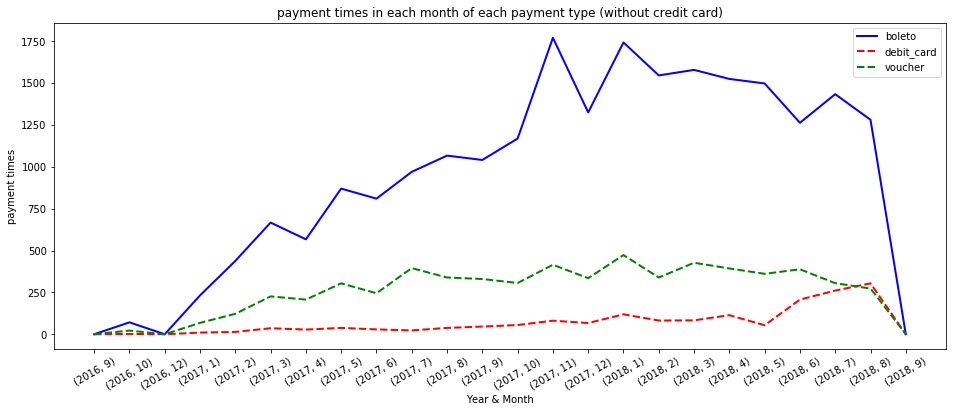

In [0]:
# plot
x = np.array([i for i in range(len(month_2))])
plt.figure(figsize=(16,6))
plt.plot( x, boleto_2, marker='', color='blue', linewidth=2, label = "boleto")
plt.plot( x, debit_card_2, marker='', color='red', linewidth=2, linestyle='dashed', label="debit_card")
plt.plot( x, voucher_2, marker='', color='green', linewidth=2, linestyle='dashed', label="voucher")
plt.xticks(x, month_2, rotation = 30)
plt.title('payment times in each month of each payment type (without credit card)')
plt.xlabel('Year & Month')
plt.ylabel('payment times')
plt.legend()

#### 6. Customer Payment Preference (unique cus ID & payment type)

##### Based on value

In [0]:
# select useful feature
cusPayV = final_order.select('customer_unique_id','customer_geolocation_lat','customer_geolocation_lng','payment_type_value')

In [0]:
# convert dataframe into rdd
cusPayVRDD = cusPayV.rdd
cusPayVRDD.take(1)

[Row(customer_unique_id=u'4f308d513ccac2840ecef09e3f27834f', customer_geolocation_lat=-16.02294658, customer_geolocation_lng=-48.05071816, payment_type_value=Row(indices=[0], size=4, type=0, values=[100.91]))]

In [0]:
# change struct feature to sparsevector
cusPayVVec = cusPayVRDD.map(lambda s: ((s[0],s[1],s[2]),s[3])).map(structToSparseVector)
cusPayVVec.take(1)

[((u'4f308d513ccac2840ecef09e3f27834f', -16.02294658, -48.05071816),
  SparseVector(4, {0: 100.91}))]

In [0]:
# reduce the order payment to one record for one unique customer
cusPayVBeh = cusPayVVec.map(lambda s: (s[0], DenseVector(s[1]))).map(lambda s: (s[0],list([i for i in s[1]]))).reduceByKey(aggreList)
cusPayVBeh.take(1)

[((u'db4c27ec046a24e8d2518c2c8f28ce96', -17.46496171, -48.20214428),
  [0.0, 96.98, 0.0, 0.0])]

In [0]:
def domiPayType(s):
  T = sum(i for i in s[1])
  for i in range(len(s[1])):
    if s[1][i] >= T/4.0:
      D = i
  return (D,s[0])
cusPayVBehDomi = cusPayVBeh.map(domiPayType)
cusPayVBehDomi.take(1)
 # find the dominant payment type
                          #  .groupByKey().map(lambda s: (s[0], [i for i in s[1]])) # aggregate the unique customers according to dominant payment type

[(1, (u'db4c27ec046a24e8d2518c2c8f28ce96', -17.46496171, -48.20214428))]

In [0]:
print "Dominant payment method :Boleto =", cusPayVBehDomi.filter(lambda s: s[0] == 0).count()
print "Dominant payment method :Credit Card =", cusPayVBehDomi.filter(lambda s: s[0] == 1).count()
print "Dominant payment method :Debit Card =", cusPayVBehDomi.filter(lambda s: s[0] == 2).count()
print "Dominant payment method :Voucher =", cusPayVBehDomi.filter(lambda s: s[0] == 3).count()



Dominant payment method :Boleto = 18961
Dominant payment method :Credit Card = 71829
Dominant payment method :Debit Card = 1500
Dominant payment method :Voucher = 3379


In [0]:
#Brazils most Northern spot is at 5 deg 16′ 27.8″ N latitude.
cusPayVBehDomi = cusPayVBehDomi.filter(lambda s: s[1][1] <= 5.27438888)
#it’s most Western spot is at 73 deg, 58′ 58.19″W Long.
cusPayVBehDomi = cusPayVBehDomi.filter(lambda s: s[1][2] >= -73.98283055)
#It’s most southern spot is at 33 deg, 45′ 04.21″ S Latitude.
cusPayVBehDomi = cusPayVBehDomi.filter(lambda s: s[1][1] >= -33.75116944)
#It’s most Eastern spot is 34 deg, 47′ 35.33″ W Long.
cusPayVBehDomi = cusPayVBehDomi.filter(lambda s: s[1][2] <=  -34.79314722)

In [0]:
pay0 = cusPayVBehDomi.filter(lambda s: s[0] == 0).map(lambda s: (s[1][0],s[1][1],s[1][2])).toDF(['customer_unique_id','customer_geolocation_lat','customer_geolocation_lng'])
pay1 = cusPayVBehDomi.filter(lambda s: s[0] == 1).map(lambda s: (s[1][0],s[1][1],s[1][2])).toDF(['customer_unique_id','customer_geolocation_lat','customer_geolocation_lng'])
pay2 = cusPayVBehDomi.filter(lambda s: s[0] == 2).map(lambda s: (s[1][0],s[1][1],s[1][2])).toDF(['customer_unique_id','customer_geolocation_lat','customer_geolocation_lng'])
pay3 = cusPayVBehDomi.filter(lambda s: s[0] == 3).map(lambda s: (s[1][0],s[1][1],s[1][2])).toDF(['customer_unique_id','customer_geolocation_lat','customer_geolocation_lng'])

In [0]:
pay0_df = pay0.toPandas()
pay1_df = pay1.toPandas()
pay2_df = pay2.toPandas()
pay3_df = pay3.toPandas()

Text(185.496,0.5,'Latitude')

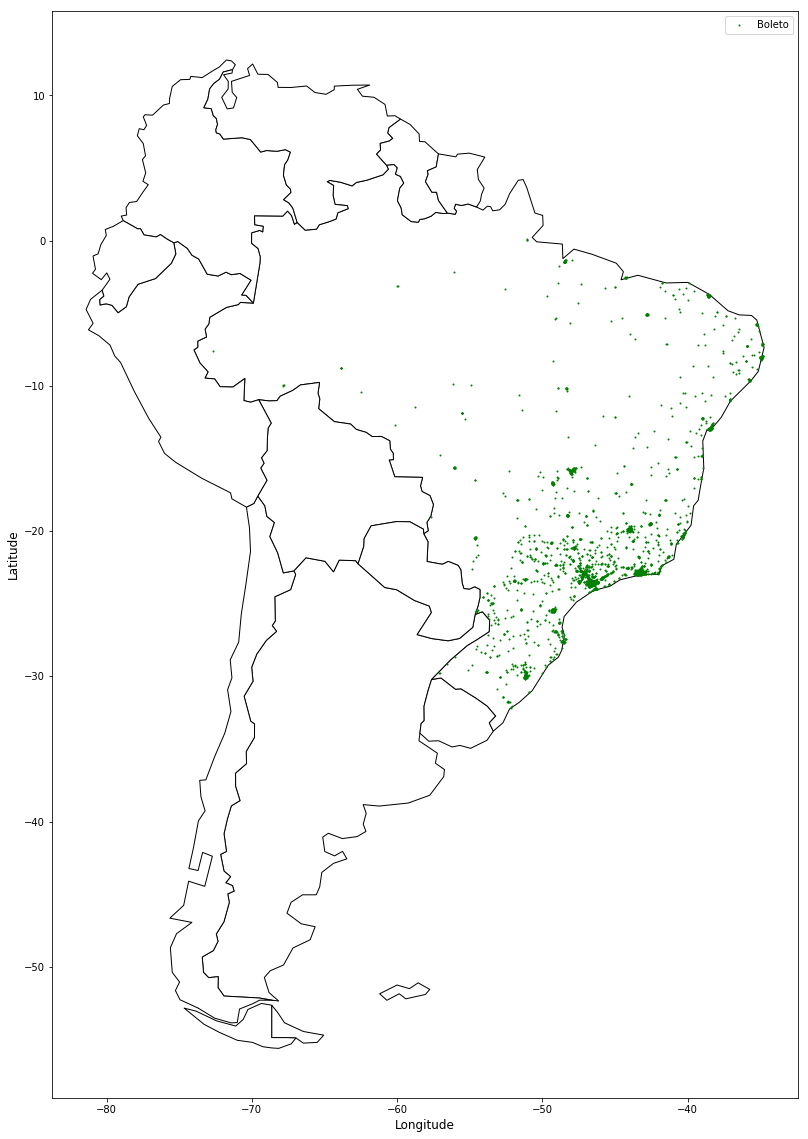

In [0]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
#fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(12,10))
# plt.ylim(40.6,40.9)
# plt.xlim(-74.1,-73.7)
ax = world[world.continent == 'South America'].plot(
    color='white', figsize=(16, 20), edgecolor='black')

# ax.scatter(pay0_df['customer_geolocation_lng'],pay0_df['customer_geolocation_lat'],c='red',s=10, alpha=1)
# ax.scatter(pay1_df['customer_geolocation_lng'],pay1_df['customer_geolocation_lat'],c='black',s=1, alpha=1)
# ax.scatter(pay2_df['customer_geolocation_lng'],pay2_df['customer_geolocation_lat'],c='blue',s=1, alpha=1)
ax.scatter(pay3_df['customer_geolocation_lng'],pay3_df['customer_geolocation_lat'],c='green',s=1, alpha=1)
ax.legend(["Boleto","Credit Card","Debit Card","Voucher"])

plt.xlabel('Longitude', fontsize = 12)
plt.ylabel('Latitude', fontsize = 12)

In this task, we can find the dominant payment type for each unique customer. Therefore, we could send the advertising e-mail or coupon based on the payment type to the specific customers, in this case, their loyalty may increase.

#### 7. Trial for Time Series Analysis on Sales on the Highest Bought Category Product

In [0]:
# get the data: year & month & day & category & price
ARData = sales_rdd.map(lambda s: ((s[13],s[14],s[15],str(s[11])),s[9]))
ARData.take(1)

[((2017, 4, 24, 'health_beauty'), 79.9)]

In [0]:
# aggregate the data based on half month
def halfMonth(s):
  if s[0][2] <= 15:
    tag = 0
  else:
    tag = 1
  return ((s[0][0],s[0][1],tag,s[0][3]),s[1])
ARHealth = ARData.map(halfMonth).reduceByKey(lambda a,b: a+b).filter(lambda s: s[0][3] == 'health_beauty').map(lambda s:((s[0][0],s[0][1],s[0][2]),s[1])).collect()

In [0]:
# sort the data based on date, eliminate the 2016 data (there are several missing months)
ARHealth.sort()
ARHealth_Del2016 = ARHealth[2:]

In [0]:
# turn the data list to array
ARHealth_Del2016 = np.array(ARHealth_Del2016)
l = ARHealth_Del2016[:,1]

In [0]:
# change each data to np.float64 type (in order for the next analyze)
w = np.random.normal(size=40)
for i in range(len(l)):
  w[i] = np.float64(l[i])

In [0]:
# normalize the data
def normalize(v): 
  norm = np.linalg.norm(v) 
  if norm == 0: 
    return v
  else:
    return v / norm
w = normalize(w)

In [0]:
# import the concerning packages
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [0]:
# define the time series plot function
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

In [0]:
ARHealth_Del2016

array([[(2017, 1, 0), 1710.69],
       [(2017, 1, 1), 10850.629999999988],
       [(2017, 2, 0), 16980.639999999985],
       [(2017, 2, 1), 5858.15],
       [(2017, 3, 0), 13451.889999999992],
       [(2017, 3, 1), 12543.359999999995],
       [(2017, 4, 0), 9710.289999999997],
       [(2017, 4, 1), 13225.45999999999],
       [(2017, 5, 0), 21700.98999999998],
       [(2017, 5, 1), 25085.02999999999],
       [(2017, 6, 0), 17351.139999999985],
       [(2017, 6, 1), 14678.249999999985],
       [(2017, 7, 0), 14550.96999999999],
       [(2017, 7, 1), 20345.88999999997],
       [(2017, 8, 0), 24672.969999999994],
       [(2017, 8, 1), 25200.92999999997],
       [(2017, 9, 0), 26807.380000000016],
       [(2017, 9, 1), 24730.269999999975],
       [(2017, 10, 0), 18033.88999999998],
       [(2017, 10, 1), 23881.829999999976],
       [(2017, 11, 0), 22077.519999999982],
       [(2017, 11, 1), 57042.88000000014],
       [(2017, 12, 0), 41667.36000000001],
       [(2017, 12, 1), 19597.299999999

In [0]:
wpd = pd.DataFrame(ARHealth_Del2016, columns = ['date','value']).set_index('date')
# .plot()

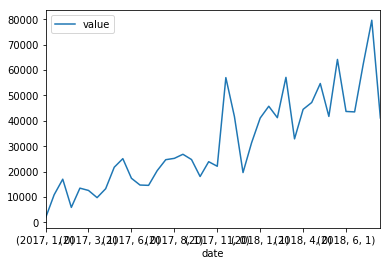

In [0]:
wpd.head()
wpd.plot()

<Figure size 432x288 with 0 Axes>

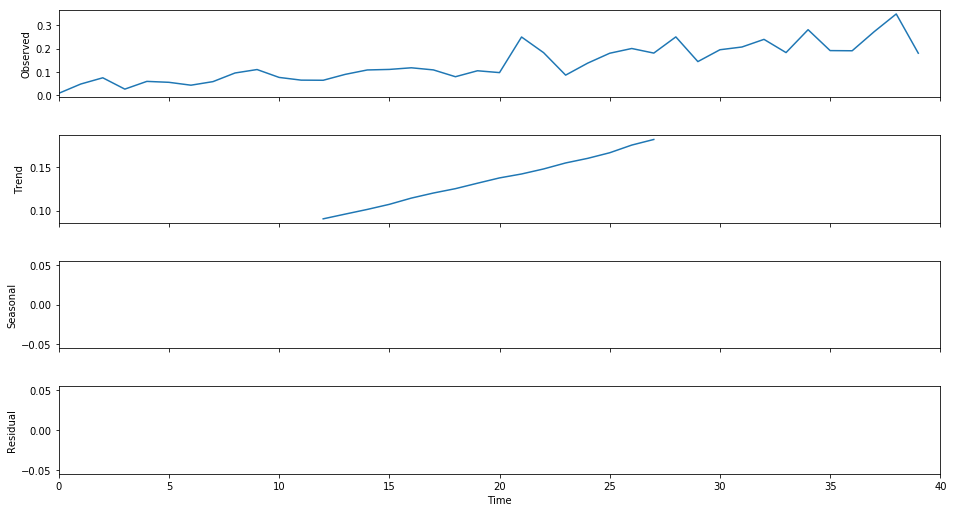

In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(w,freq=24)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15,8)

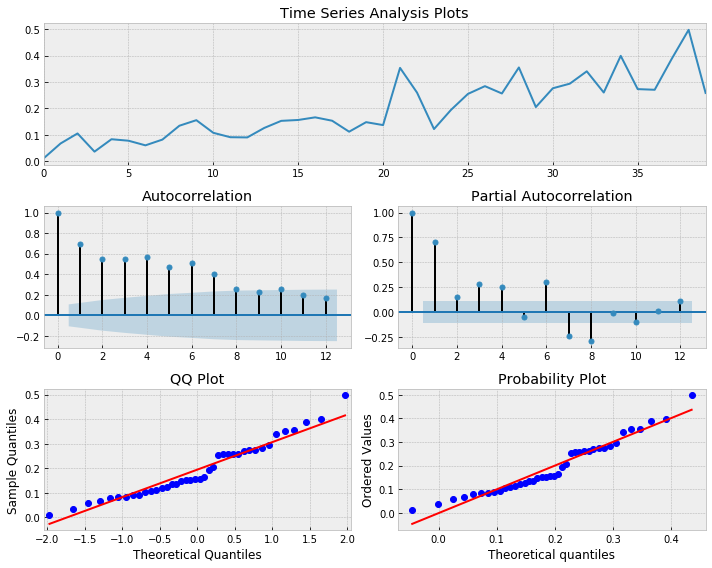

In [0]:
a0 = 2
a1 = .5

Y = np.empty_like(w)

for t in range(len(w)):
    Y[t] = w[t] * np.sqrt((a0 + a1*w[t-1]**2))

# simulated ARCH(1) series, looks like white noise
tsplot(Y, lags=12)

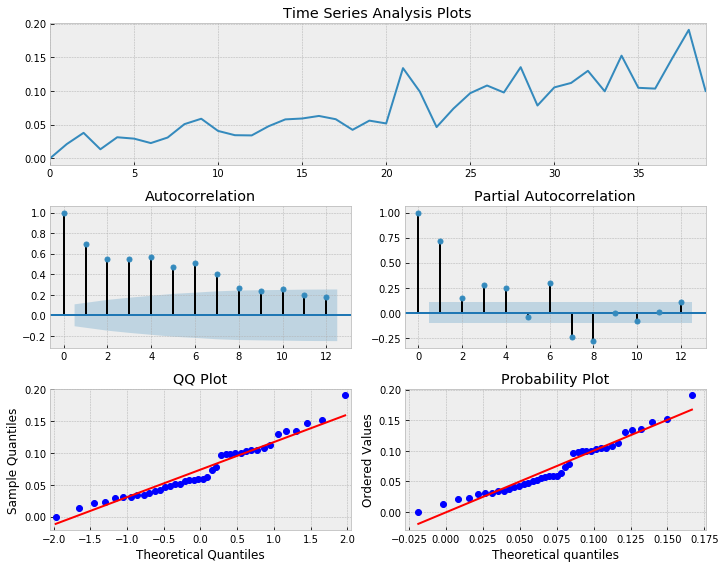

In [0]:
# try a function based on the data
a0 = 0.2
a1 = 0.5
b1 = 0.3

eps = np.zeros_like(w)
sigsq = np.zeros_like(w)

for i in range(1, 40):
    sigsq[i] = a0 + a1*(eps[i-1]**2) + b1*sigsq[i-1]
    eps[i] = w[i] * np.sqrt(sigsq[i])

_ = tsplot(eps, lags=12)

In [0]:
am = arch_model(eps)
res = am.fit(update_freq=5)
print res.summary()

Iteration:      5,   Func. Count:     41,   Neg. LLF: -71.2189911784
Iteration:     10,   Func. Count:     75,   Neg. LLF: -71.3969596263
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -71.3978099269
            Iterations: 12
            Function evaluations: 88
            Gradient evaluations: 12
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.114
Mean Model:             Constant Mean   Adj. R-squared:                 -0.114
Vol Model:                      GARCH   Log-Likelihood:                71.3978
Distribution:                  Normal   AIC:                          -134.796
Method:            Maximum Likelihood   BIC:                          -128.040
                                        No. Observations:                   40
Date:                Wed, Dec 04 2019   Df Residuals:                       36
Time:                  

In [0]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print 'aic: {:6.5f} | order: {}'.format(best_aic, best_order)            
    return best_aic, best_order, best_mdl

# Notice I've selected a specific time period to run this analysis
TS = w
res_tup = _get_best_model(TS)

aic: -120.19318 | order: (3, 1, 0)


In [0]:
res_tup

(-120.19318227188688,
 (3, 1, 0),
 <statsmodels.tsa.arima_model.ARIMAResultsWrapper at 0x7ff8d644de50>)

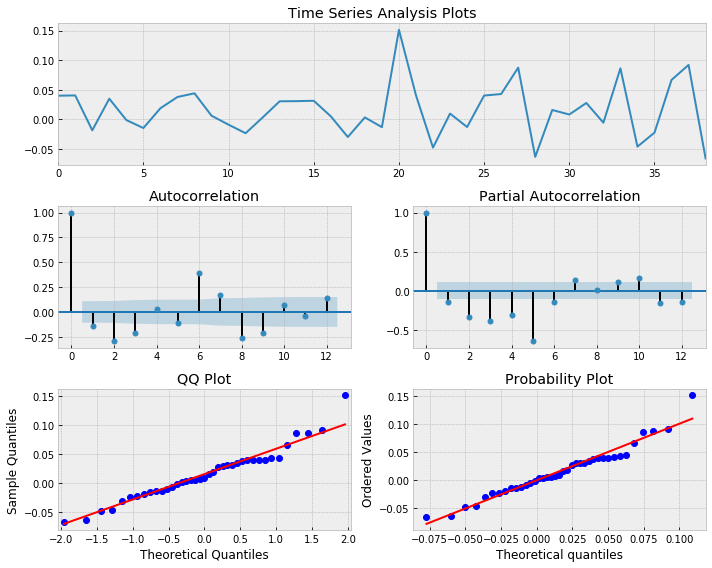

In [0]:
# residual of the model
_ = tsplot(res_tup[2].resid, lags=12)

In [0]:
p_ = res_tup[1][0]
o_ = res_tup[1][1]
q_ = res_tup[1][2]

# Using student T distribution usually provides better fit
am = arch_model(TS, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print res.summary()

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                      -0.316
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.316
Vol Model:                        GJR-GARCH   Log-Likelihood:                49.6452
Distribution:      Standardized Student's t   AIC:                          -85.2904
Method:                  Maximum Likelihood   BIC:                          -73.4683
                                              No. Observations:                   40
Date:                      Wed, Dec 04 2019   Df Residuals:                       33
Time:                              00:06:50   Df Model:                            7
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

### Clustering

#### Customer


##### Total payment

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas

In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.clustering import KMeans

import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sbs
from matplotlib.ticker import MaxNLocator

final_order1 = final_order.where(final_order.total_payment.isNotNull()).where(final_order['freight/price'].isNotNull())

vecAssembler1 = VectorAssembler(inputCols=['total_payment'], outputCol='features0')
customer_total_payment = vecAssembler1.transform(final_order1)
customer_total_payment.show(3)

+--------------------------+--------------------------------------+----------------------+-----------------------+------------------------------+------------------+------------------------+-------------------+-------------+------------------------+------------------------+--------------------+--------------+--------------------+------------------------+-------------------+-------------+---+--------------------+----------------------------+-----------------------------+-----------------------------+--------------------+-------------+------------------------+------------+------------------+--------------------+-----+-----------------------------+--------------------------+-----------------+--------------------+-----------------+-------------------+------------------+----------------+----------------+----------------------+--------------------+------------+-----------+----------------------+----------------------+--------------------+------------+----------------------+-------------------

In [0]:
# Let us create an object of MinMaxScaler class
MinMaxScalerizer=MinMaxScaler().setMin(5).setMax(10).setInputCol("features0").setOutputCol("features")
customer_total_payment1 = MinMaxScalerizer.fit(customer_total_payment).transform(customer_total_payment)
customer_total_payment1.show(3)

+--------------------------+--------------------------------------+----------------------+-----------------------+------------------------------+------------------+------------------------+-------------------+-------------+------------------------+------------------------+--------------------+--------------+--------------------+------------------------+-------------------+-------------+---+--------------------+----------------------------+-----------------------------+-----------------------------+--------------------+-------------+------------------------+------------+------------------+--------------------+-----+-----------------------------+--------------------------+-----------------+--------------------+-----------------+-------------------+------------------+----------------+----------------+----------------------+--------------------+------------+-----------+----------------------+----------------------+--------------------+------------+----------------------+-------------------

In [0]:
wssse = np.zeros(60)
for k in range(2,60):
    kmeans = KMeans(featuresCol='features',k=k)
    model = kmeans.fit(customer_total_payment1.select('features'))
    wssse[k] = model.computeCost(customer_total_payment1.select('features'))
    print("With K={}".format(k))
    print("Within Set Sum of Squared Errors = " + str(wssse[k]))
    print('--'*30)

With K=2
Within Set Sum of Squared Errors = 880.1629693162159
------------------------------------------------------------
With K=3
Within Set Sum of Squared Errors = 374.9485823354386
------------------------------------------------------------
With K=4
Within Set Sum of Squared Errors = 229.98178029905034
------------------------------------------------------------
With K=5
Within Set Sum of Squared Errors = 149.34177062360715
------------------------------------------------------------
With K=6
Within Set Sum of Squared Errors = 107.31012188816982
------------------------------------------------------------
With K=7
Within Set Sum of Squared Errors = 77.25006070829005
------------------------------------------------------------
With K=8
Within Set Sum of Squared Errors = 54.19904002368793
------------------------------------------------------------
With K=9
Within Set Sum of Squared Errors = 43.31045753231169
------------------------------------------------------------
With K=10
Wit

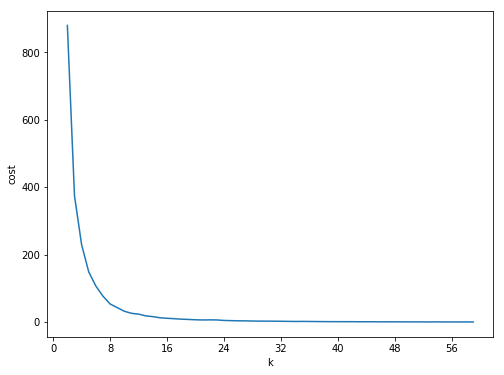

In [0]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,60),wssse[2:60])
ax.set_xlabel('k')
ax.set_ylabel('cost')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [0]:
kmeans = KMeans(k=4, seed=1)  # 2 clusters here
model = kmeans.fit(customer_total_payment1.select('features'))

In [0]:
transformed = model.transform(customer_total_payment1)
transformed.show(3)

+--------------------------+--------------------------------------+----------------------+-----------------------+------------------------------+------------------+------------------------+-------------------+-------------+------------------------+------------------------+--------------------+--------------+--------------------+------------------------+-------------------+-------------+---+--------------------+----------------------------+-----------------------------+-----------------------------+--------------------+-------------+------------------------+------------+------------------+--------------------+-----+-----------------------------+--------------------------+-----------------+--------------------+-----------------+-------------------+------------------+----------------+----------------+----------------------+--------------------+------------+-----------+----------------------+----------------------+--------------------+------------+----------------------+-------------------

In [0]:
#Brazils most Northern spot is at 5 deg 16′ 27.8″ N latitude.;
transformed = transformed[transformed.customer_geolocation_lat <= 5.27438888]
#it’s most Western spot is at 73 deg, 58′ 58.19″W Long.
transformed = transformed[transformed.customer_geolocation_lng >= -73.98283055]
#It’s most southern spot is at 33 deg, 45′ 04.21″ S Latitude.
transformed = transformed[transformed.customer_geolocation_lat >= -33.75116944]
#It’s most Eastern spot is 34 deg, 47′ 35.33″ W Long.
transformed = transformed[transformed.customer_geolocation_lng <=  -34.79314722]

In [0]:
transformed_df = transformed.toPandas()

In [0]:
clu0 = transformed_df.where(transformed_df.prediction == 0)
clu1 = transformed_df.where(transformed_df.prediction == 1)
clu2 = transformed_df.where(transformed_df.prediction == 2)
clu3 = transformed_df.where(transformed_df.prediction == 3)

In [0]:
clu3['total_payment'].mean()

1934.4821367521367

Text(0.5,1,'RED-$121.79, PURPLE-$586.60 , BLUE-$13664.08, GREEN-$1934.48 ')

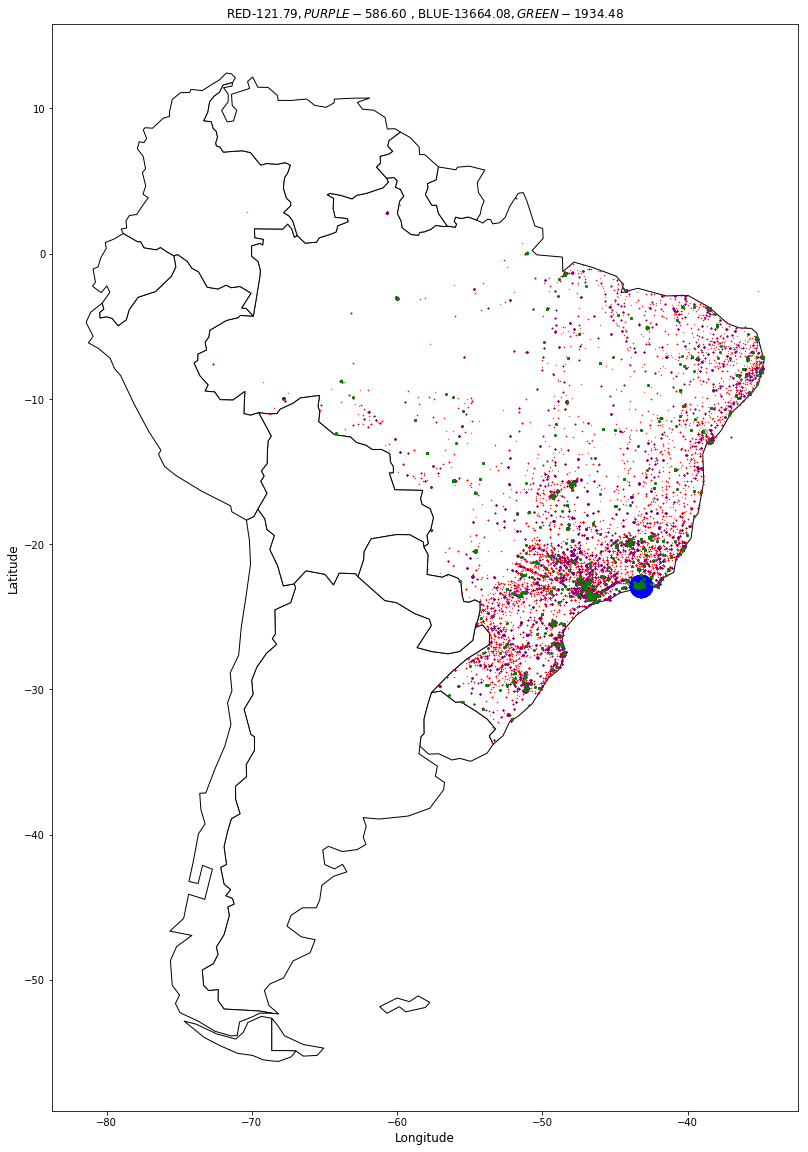

In [0]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
#fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(12,10))
# plt.ylim(40.6,40.9)
# plt.xlim(-74.1,-73.7)
ax = world[world.continent == 'South America'].plot(
    color='white', figsize=(16, 20), edgecolor='black')

ax.scatter(clu0['customer_geolocation_lng'],clu0['customer_geolocation_lat'],c='red',s=0.1, alpha=1) #101742 count, mean $121.79
ax.scatter(clu1['customer_geolocation_lng'],clu1['customer_geolocation_lat'],c='purple',s=1, alpha=1) #9834 count , mean $586.60
ax.scatter(clu2['customer_geolocation_lng'],clu2['customer_geolocation_lat'],c='blue',s=500, alpha=1) #8 count , mean $13664.08
ax.scatter(clu3['customer_geolocation_lng'],clu3['customer_geolocation_lat'],c='green',s=4, alpha=1) #1053 count, mean $1934.48

plt.xlabel('Longitude', fontsize = 12)
plt.ylabel('Latitude', fontsize = 12)
plt.title('RED-$121.79, PURPLE-$586.60 , BLUE-$13664.08, GREEN-$1934.48 ')

Text(185.496,0.5,'Latitude')

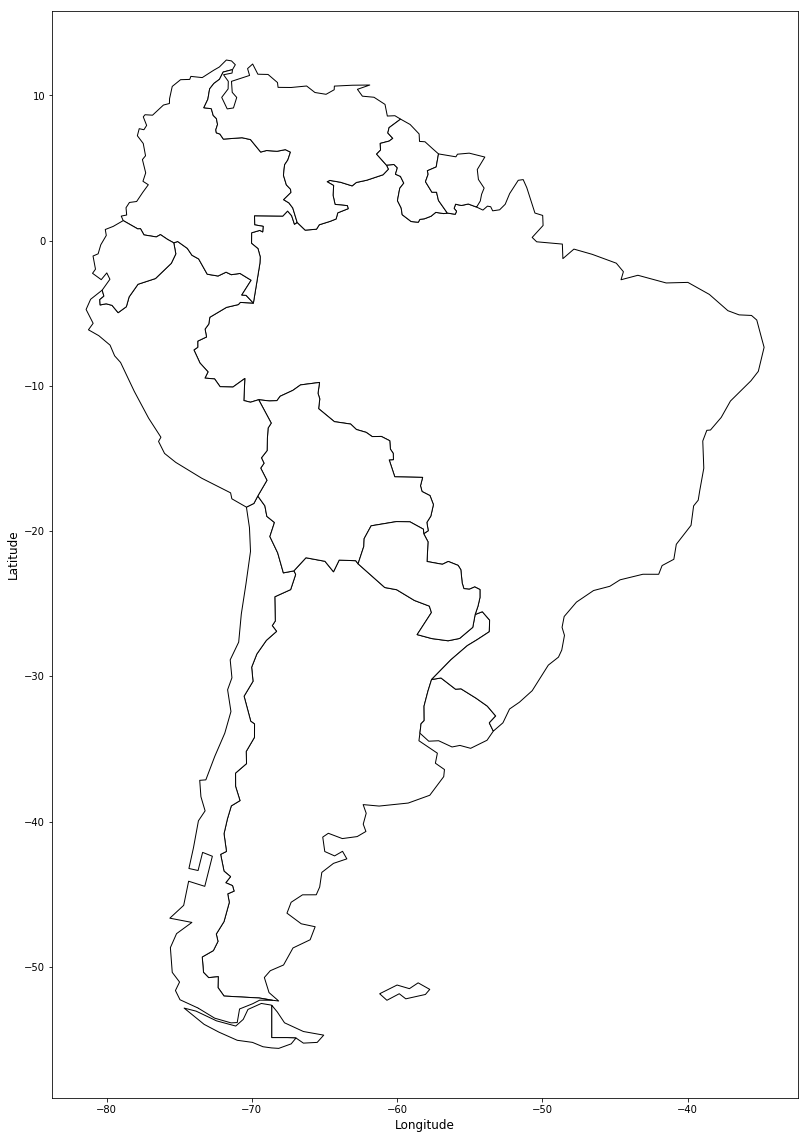

In [0]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
#fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(12,10))
# plt.ylim(40.6,40.9)
# plt.xlim(-74.1,-73.7)
ax = world[world.continent == 'South America'].plot(
    color='white', figsize=(16, 20), edgecolor='black')

# ax.scatter(clu0['customer_geolocation_lng'],clu0['customer_geolocation_lat'],c='green',s=0.1, alpha=1)
# ax.scatter(clu1['customer_geolocation_lng'],clu1['customer_geolocation_lat'],c='purple',s=0.1, alpha=1)
# ax.scatter(clu2['customer_geolocation_lng'],clu2['customer_geolocation_lat'],c='blue',s=0.1, alpha=1)
# ax.scatter(clu3['customer_geolocation_lng'],clu3['customer_geolocation_lat'],c='red',s=0.1, alpha=1)


plt.xlabel('Longitude', fontsize = 12)
plt.ylabel('Latitude', fontsize = 12)

##### Freight Ratio 

In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.clustering import KMeans

import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sbs
from matplotlib.ticker import MaxNLocator

final_order1 = final_order.where(final_order.total_payment.isNotNull()).where(final_order['freight/price'].isNotNull())

vecAssembler1 = VectorAssembler(inputCols=['freight/price'], outputCol='features0')
customer_total_payment = vecAssembler1.transform(final_order1)
customer_total_payment.show(3)

+--------------------------+--------------------------------------+----------------------+-----------------------+------------------------------+------------------+------------------------+-------------------+-------------+------------------------+------------------------+--------------------+--------------+--------------------+------------------------+-------------------+-------------+---+--------------------+----------------------------+-----------------------------+-----------------------------+--------------------+-------------+------------------------+------------+------------------+--------------------+-----+-----------------------------+--------------------------+-----------------+--------------------+-----------------+-------------------+------------------+----------------+----------------+----------------------+--------------------+------------+-----------+----------------------+----------------------+--------------------+------------+----------------------+-------------------

In [0]:
# Let us create an object of MinMaxScaler class
MinMaxScalerizer=MinMaxScaler().setMin(5).setMax(10).setInputCol("features0").setOutputCol("features")
customer_total_payment1 = MinMaxScalerizer.fit(customer_total_payment).transform(customer_total_payment)
customer_total_payment1.show(3)

+--------------------------+--------------------------------------+----------------------+-----------------------+------------------------------+------------------+------------------------+-------------------+-------------+------------------------+------------------------+--------------------+--------------+--------------------+------------------------+-------------------+-------------+---+--------------------+----------------------------+-----------------------------+-----------------------------+--------------------+-------------+------------------------+------------+------------------+--------------------+-----+-----------------------------+--------------------------+-----------------+--------------------+-----------------+-------------------+------------------+----------------+----------------+----------------------+--------------------+------------+-----------+----------------------+----------------------+--------------------+------------+----------------------+-------------------

In [0]:
wssse = np.zeros(60)
for k in range(2,60,5):
    kmeans = KMeans(featuresCol='features',k=k)
    model = kmeans.fit(customer_total_payment1.select('features'))
    wssse[k] = model.computeCost(customer_total_payment1.select('features'))
    print("With K={}".format(k))
    print("Within Set Sum of Squared Errors = " + str(wssse[k]))
    print('--'*30)

With K=2
Within Set Sum of Squared Errors = 258.4192235795838
------------------------------------------------------------
With K=7
Within Set Sum of Squared Errors = 56.493238503147666
------------------------------------------------------------
With K=12
Within Set Sum of Squared Errors = 12.90480306233296
------------------------------------------------------------
With K=17
Within Set Sum of Squared Errors = 6.567780020423398
------------------------------------------------------------
With K=22
Within Set Sum of Squared Errors = 3.5229157823413813
------------------------------------------------------------
With K=27
Within Set Sum of Squared Errors = 2.545228621958005
------------------------------------------------------------
With K=32
Within Set Sum of Squared Errors = 1.5659541241441084
------------------------------------------------------------
With K=37
Within Set Sum of Squared Errors = 1.1178665412356776
------------------------------------------------------------
With K

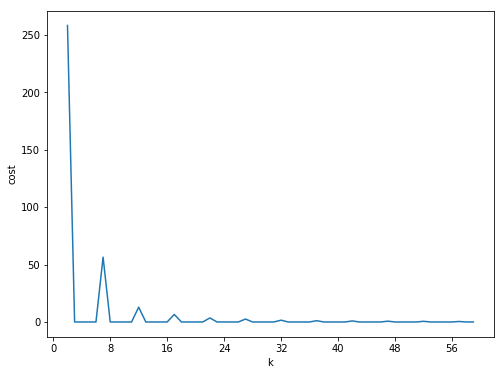

In [0]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,60),wssse[2:60])
ax.set_xlabel('k')
ax.set_ylabel('cost')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [0]:
kmeans = KMeans(k=4, seed=1)  # 2 clusters here
model = kmeans.fit(customer_total_payment1.select('features'))

In [0]:
transformed = model.transform(customer_total_payment1)
transformed.show(3)

+--------------------------+--------------------------------------+----------------------+-----------------------+------------------------------+------------------+------------------------+-------------------+-------------+------------------------+------------------------+--------------------+--------------+--------------------+------------------------+-------------------+-------------+---+--------------------+----------------------------+-----------------------------+-----------------------------+--------------------+-------------+------------------------+------------+------------------+--------------------+-----+-----------------------------+--------------------------+-----------------+--------------------+-----------------+-------------------+------------------+----------------+----------------+----------------------+--------------------+------------+-----------+----------------------+----------------------+--------------------+------------+----------------------+-------------------

In [0]:
#Brazils most Northern spot is at 5 deg 16′ 27.8″ N latitude.;
transformed = transformed[transformed.customer_geolocation_lat <= 5.27438888]
#it’s most Western spot is at 73 deg, 58′ 58.19″W Long.
transformed = transformed[transformed.customer_geolocation_lng >= -73.98283055]
#It’s most southern spot is at 33 deg, 45′ 04.21″ S Latitude.
transformed = transformed[transformed.customer_geolocation_lat >= -33.75116944]
#It’s most Eastern spot is 34 deg, 47′ 35.33″ W Long.
transformed = transformed[transformed.customer_geolocation_lng <=  -34.79314722]

In [0]:
transformed_df = transformed.toPandas()

In [0]:
clu0 = transformed_df.where(transformed_df.prediction == 0)
clu1 = transformed_df.where(transformed_df.prediction == 1)
clu2 = transformed_df.where(transformed_df.prediction == 2)
clu3 = transformed_df.where(transformed_df.prediction == 3)

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas

Text(185.496,0.5,'Latitude')

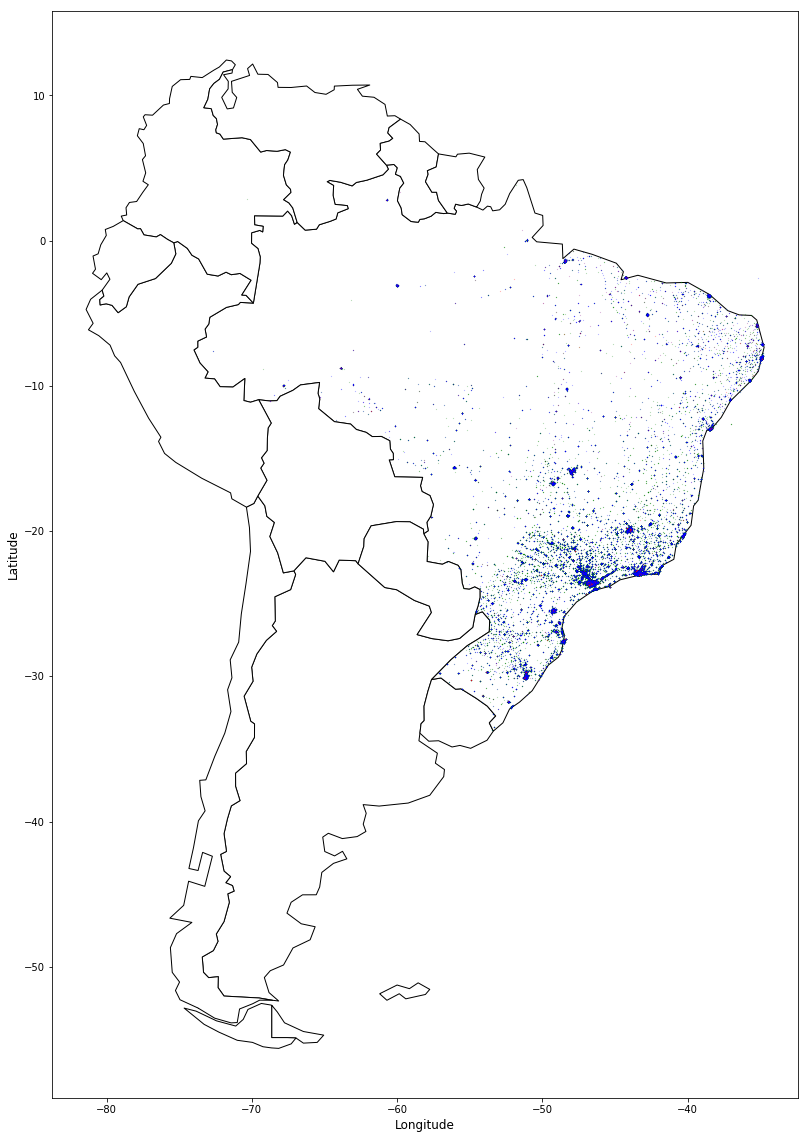

In [0]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
#fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(12,10))
# plt.ylim(40.6,40.9)
# plt.xlim(-74.1,-73.7)
ax = world[world.continent == 'South America'].plot(
    color='white', figsize=(16, 20), edgecolor='black')

ax.scatter(clu0['customer_geolocation_lng'],clu0['customer_geolocation_lat'],c='green',s=0.01, alpha=1)
ax.scatter(clu1['customer_geolocation_lng'],clu1['customer_geolocation_lat'],c='purple',s=0.01, alpha=1)
ax.scatter(clu2['customer_geolocation_lng'],clu2['customer_geolocation_lat'],c='blue',s=0.01, alpha=1)
ax.scatter(clu3['customer_geolocation_lng'],clu3['customer_geolocation_lat'],c='red',s=0.01, alpha=1)

plt.xlabel('Longitude', fontsize = 12)
plt.ylabel('Latitude', fontsize = 12)

##### Payment type

In [0]:
from pyspark.sql.functions import *
from pyspark.ml.linalg import SparseVector, DenseVector
final_order4 = final_order.where(final_order.payment_type_value.isNotNull()).where(final_order.payment_type_count.isNotNull())
final_order5 = final_order4.withColumn("payment_type_value_value", col("payment_type_value").getField("values"))\
                           .withColumn("payment_type_value_index", col("payment_type_value").getField("indices"))
final_order5.show(3)

+--------------------------+--------------------------------------+----------------------+-----------------------+------------------------------+------------------+------------------------+-------------------+-------------+------------------------+------------------------+--------------------+--------------+--------------------+------------------------+-------------------+-------------+---+--------------------+----------------------------+-----------------------------+-----------------------------+--------------------+-------------+------------------------+------------+------------------+--------------------+-----+-----------------------------+--------------------------+-----------------+--------------------+-----------------+-------------------+------------------+----------------+----------------+----------------------+--------------------+------------+-----------+----------------------+----------------------+--------------------+------------+----------------------+-------------------

In [0]:
customer_payment_type = final_order5.rdd.map(lambda s: (s[9],s[10],DenseVector(SparseVector(4,s[50],s[49])))).toDF(['customer_geolocation_lat','customer_geolocation_lng','features0'])
customer_payment_type.show(3)

+------------------------+------------------------+--------------------+
|customer_geolocation_lat|customer_geolocation_lng|           features0|
+------------------------+------------------------+--------------------+
|            -16.02294658|            -48.05071816|[100.91,0.0,0.0,0.0]|
|            -27.23090863|             -52.0454811| [0.0,56.42,0.0,0.0]|
|            -21.12102843|            -48.97081828| [59.82,0.0,0.0,0.0]|
+------------------------+------------------------+--------------------+
only showing top 3 rows



In [0]:
# Let us create an object of MinMaxScaler class
MinMaxScalerizer=MinMaxScaler().setMin(5).setMax(10).setInputCol("features0").setOutputCol("features")
customer_payment_type1 = MinMaxScalerizer.fit(customer_payment_type).transform(customer_payment_type)
customer_payment_type1.show(3)

+------------------------+------------------------+--------------------+--------------------+
|customer_geolocation_lat|customer_geolocation_lng|           features0|            features|
+------------------------+------------------------+--------------------+--------------------+
|            -16.02294658|            -48.05071816|[100.91,0.0,0.0,0.0]|[5.06935509589161...|
|            -27.23090863|             -52.0454811| [0.0,56.42,0.0,0.0]|[5.0,5.0206453709...|
|            -21.12102843|            -48.97081828| [59.82,0.0,0.0,0.0]|[5.04111408023225...|
+------------------------+------------------------+--------------------+--------------------+
only showing top 3 rows



In [0]:
wssse = np.zeros(10)
for k in range(2,10):
    kmeans = KMeans(featuresCol='features',k=k)
    model = kmeans.fit(customer_payment_type1.select('features'))
    wssse[k] = model.computeCost(customer_payment_type1.select('features'))
    print("With K={}".format(k))
    print("Within Set Sum of Squared Errors = " + str(wssse[k]))
    print('--'*30)

With K=2
Within Set Sum of Squared Errors = 2408.1241928370578
------------------------------------------------------------
With K=3
Within Set Sum of Squared Errors = 2028.8040589543587
------------------------------------------------------------
With K=4
Within Set Sum of Squared Errors = 1829.6146532408034
------------------------------------------------------------
With K=5
Within Set Sum of Squared Errors = 1758.1999795266734
------------------------------------------------------------
With K=6
Within Set Sum of Squared Errors = 1259.3414838635035
------------------------------------------------------------
With K=7
Within Set Sum of Squared Errors = 1237.262003397493
------------------------------------------------------------
With K=8
Within Set Sum of Squared Errors = 844.8823517542446
------------------------------------------------------------
With K=9
Within Set Sum of Squared Errors = 786.3294274027412
------------------------------------------------------------


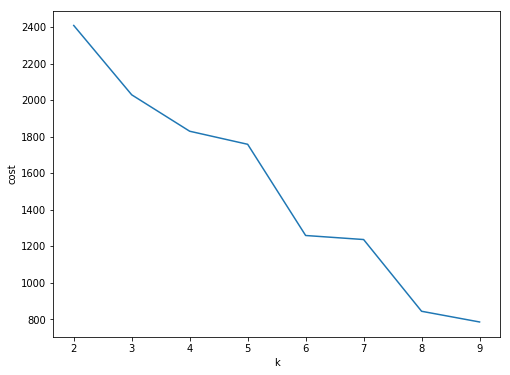

In [0]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),wssse[2:10])
ax.set_xlabel('k')
ax.set_ylabel('cost')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [0]:
kmeans = KMeans(k=4, seed=1)  # 2 clusters here
model = kmeans.fit(customer_payment_type1.select('features'))

In [0]:
transformed1 = model.transform(customer_payment_type1)
transformed1.show(3)

+------------------------+------------------------+--------------------+--------------------+----------+
|customer_geolocation_lat|customer_geolocation_lng|           features0|            features|prediction|
+------------------------+------------------------+--------------------+--------------------+----------+
|            -16.02294658|            -48.05071816|[100.91,0.0,0.0,0.0]|[5.06935509589161...|         0|
|            -27.23090863|             -52.0454811| [0.0,56.42,0.0,0.0]|[5.0,5.0206453709...|         0|
|            -21.12102843|            -48.97081828| [59.82,0.0,0.0,0.0]|[5.04111408023225...|         0|
+------------------------+------------------------+--------------------+--------------------+----------+
only showing top 3 rows



In [0]:
transformed1_df = transformed1.toPandas()

In [0]:
clu0 = transformed1_df.where(transformed1_df.prediction == 0)
clu1 = transformed1_df.where(transformed1_df.prediction == 1)
clu2 = transformed1_df.where(transformed1_df.prediction == 2)
clu3 = transformed1_df.where(transformed1_df.prediction == 3)

Text(185.496,0.5,'Latitude')

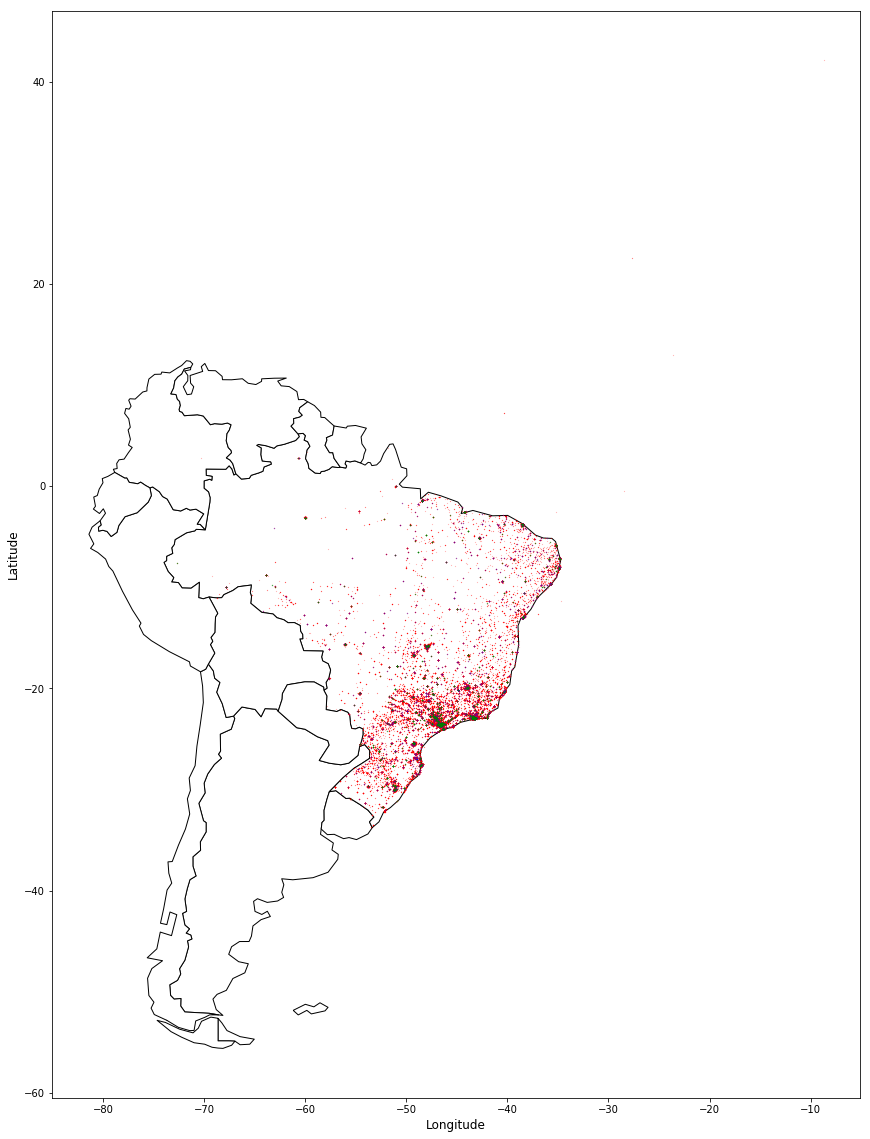

In [0]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
#fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(12,10))
# plt.ylim(40.6,40.9)
# plt.xlim(-74.1,-73.7)
ax = world[world.continent == 'South America'].plot(
    color='white', figsize=(16, 20), edgecolor='black')

ax.scatter(clu0['customer_geolocation_lng'],clu0['customer_geolocation_lat'],c='red',s=0.01, alpha=1)
ax.scatter(clu1['customer_geolocation_lng'],clu1['customer_geolocation_lat'],c='purple',s=0.1, alpha=1)
ax.scatter(clu2['customer_geolocation_lng'],clu2['customer_geolocation_lat'],c='blue',s=0.1, alpha=1)
ax.scatter(clu3['customer_geolocation_lng'],clu3['customer_geolocation_lat'],c='green',s=0.1, alpha=1)

plt.xlabel('Longitude', fontsize = 12)
plt.ylabel('Latitude', fontsize = 12)

##### Late/On-Time Visalization

In [0]:
final_order.show()

+--------------------------+--------------------------------------+----------------------+-----------------------+------------------------------+------------------+------------------------+-------------------+---------------+------------------------+------------------------+--------------------+--------------+--------------------+------------------------+-------------------+-------------+---+--------------------+----------------------------+-----------------------------+-----------------------------+--------------------+-------------+------------------------+------------+--------------------+--------------------+-----+-----------------------------+--------------------------+-----------------+--------------------+-----------------+-------------------+------------------+----------------+----------------+----------------------+--------------------+------------+-----------+----------------------+----------------------+--------------------+------------+----------------------+---------------

In [0]:

lateontime = final_order.select('customer_unique_id','customer_geolocation_lat','customer_geolocation_lng','review_score')

#Brazils most Northern spot is at 5 deg 16′ 27.8″ N latitude.;
lateontime = lateontime[lateontime.customer_geolocation_lat <= 5.27438888]
#it’s most Western spot is at 73 deg, 58′ 58.19″W Long.
lateontime = lateontime[lateontime.customer_geolocation_lng >= -73.98283055]
#It’s most southern spot is at 33 deg, 45′ 04.21″ S Latitude.
lateontime = lateontime[lateontime.customer_geolocation_lat >= -33.75116944]
#It’s most Eastern spot is 34 deg, 47′ 35.33″ W Long.
lateontime = lateontime[lateontime.customer_geolocation_lng <=  -34.79314722]

lateontime = lateontime.withColumnRenamed('review_score','label')
lateontime_df = lateontime.toPandas()
# lateontime_df


In [0]:
clu0 = lateontime_df.where(lateontime_df.label <= 3)
clu1 = lateontime_df.where(lateontime_df.label == 4)
clu2 = lateontime_df.where(lateontime_df.label == 5)


In [0]:
clu0.count()

customer_unique_id          28131
customer_geolocation_lat    28131
customer_geolocation_lng    28131
label                       28131
dtype: int64

Text(0.5,1,'Orders : RED- Rating<=3, BLACK-Rating=4 , BLUE-Rating=5 ')

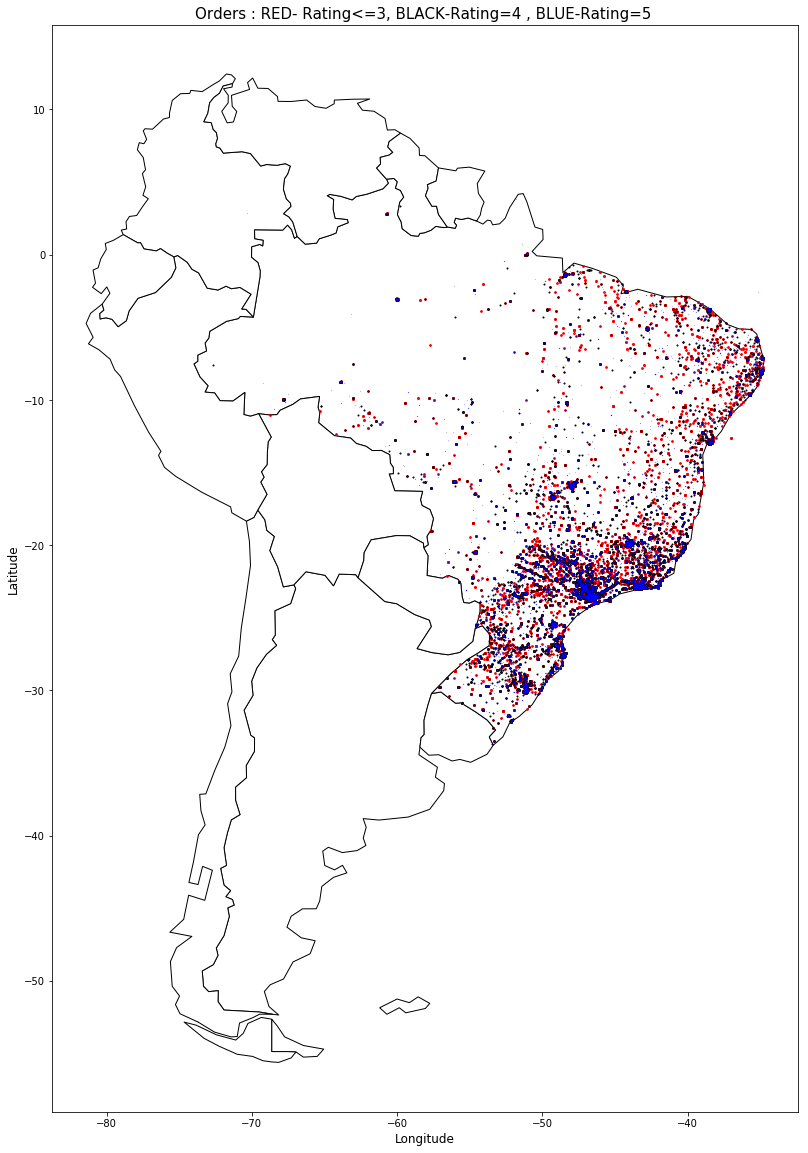

In [0]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
#fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(12,10))
# plt.ylim(40.6,40.9)
# plt.xlim(-74.1,-73.7)
ax = world[world.continent == 'South America'].plot(
    color='white', figsize=(16, 20), edgecolor='black')

ax.scatter(clu0['customer_geolocation_lng'],clu0['customer_geolocation_lat'],c='red',s=3, alpha=1) 
ax.scatter(clu1['customer_geolocation_lng'],clu1['customer_geolocation_lat'],c='black',s=1, alpha=1) 
ax.scatter(clu2['customer_geolocation_lng'],clu2['customer_geolocation_lat'],c='blue',s=0.01, alpha=1) 

plt.xlabel('Longitude', fontsize = 12)
plt.ylabel('Latitude', fontsize = 12)
plt.title('Orders : RED- Rating<=3, BLACK-Rating=4 , BLUE-Rating=5 ' , fontsize = 15)

In [0]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
#fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(12,10))
# plt.ylim(40.6,40.9)
# plt.xlim(-74.1,-73.7)
ax = world[world.continent == 'South America'].plot(
    color='white', figsize=(16, 20), edgecolor='black')

# ax.scatter(clu0['customer_geolocation_lng'],clu0['customer_geolocation_lat'],c='green',s=0.1, alpha=1)
# ax.scatter(clu1['customer_geolocation_lng'],clu1['customer_geolocation_lat'],c='purple',s=0.1, alpha=1)
# ax.scatter(clu2['customer_geolocation_lng'],clu2['customer_geolocation_lat'],c='blue',s=0.1, alpha=1)
# ax.scatter(clu3['customer_geolocation_lng'],clu3['customer_geolocation_lat'],c='red',s=0.1, alpha=1)


plt.xlabel('Longitude', fontsize = 12)
plt.ylabel('Latitude', fontsize = 12)